## Incidence du syndrome varicelle

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import numpy as np

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/france/fr/?). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.

In [4]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):
La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant skiprows=1.

Pour nous protéger contre une éventuelle disparition ou modification du serveur du Réseau Sentinelles, nous faisons une copie locale de ce jeux de données que nous préservons avec notre analyse. Il est inutile et même risquée de télécharger les données à chaque exécution, car dans le cas d'une panne nous pourrions remplacer nos données par un fichier défectueux. Pour cette raison, nous téléchargeons les données seulement si la copie locale n'existe pas.

In [5]:
data_file = "syndrome-varicelle.csv"
import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

In [6]:
raw_data = pd.read_csv("syndrome-varicelle.csv", skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202119          7   8060     4941   11179      12           7   
1     202118          7   3932     2093    5771       6           3   
2     202117          7   4686     2878    6494       7           4   
3     202116          7   4780     2891    6669       7           4   
4     202115          7  11215     7627   14803      17          12   
5     202114          7  11197     7994   14400      17          12   
6     202113          7   9714     6289   13139      15          10   
7     202112          7  11520     8415   14625      17          12   
8     202111          7   9386     6678   12094      14          10   
9     202110          7   9056     6452   11660      14          10   
10    202109          7  10988     7938   14038      17          12   
11    202108          7  11281     8361   14201      17          13   
12    202107          7  13561    10315   16807      21          16   
13    202106          7  13401     9810   16992      20          15   
14    202105          7  12210     8988   15432      18          13   
15    202104          7  12026     8826   15226      18          13   
16    202103          7   8913     6375   11451      13           9   
17    202102          7   7795     5430   10160      12           8   
18    202101          7  10525     7750   13300      16          12   
19    202053          7  11978     8406   15550      18          13   
20    202052          7  12012     8285   15739      18          12   
21    202051          7  10564     7574   13554      16          11   
22    202050          7   7063     4744    9382      11           7   
23    202049          7   5026     3145    6907       8           5   
24    202048          7   6683     4312    9054      10           6   
25    202047          7   4999     2963    7035       8           5   
26    202046          7   3752     1963    5541       6           3   
27    202045          7   3696     2016    5376       6           3   
28    202044          7   4391     2375    6407       7           4   
29    202043          7   4376     2505    6247       7           4   
...      ...        ...    ...      ...     ...     ...         ...   
1559  199126          7  17608    11304   23912      31          20   
1560  199125          7  16169    10700   21638      28          18   
1561  199124          7  16171    10071   22271      28          17   
1562  199123          7  11947     7671   16223      21          13   
1563  199122          7  15452     9953   20951      27          17   
1564  199121          7  14903     8975   20831      26          16   
1565  199120          7  19053    12742   25364      34          23   
1566  199119          7  16739    11246   22232      29          19   
1567  199118          7  21385    13882   28888      38          25   
1568  199117          7  13462     8877   18047      24          16   
1569  199116          7  14857    10068   19646      26          18   
1570  199115          7  13975     9781   18169      25          18   
1571  199114          7  12265     7684   16846      22          14   
1572  199113          7   9567     6041   13093      17          11   
1573  199112          7  10864     7331   14397      19          13   
1574  199111          7  15574    11184   19964      27          19   
1575  199110          7  16643    11372   21914      29          20   
1576  199109          7  13741     8780   18702      24          15   
1577  199108          7  13289     8813   17765      23          15   
1578  199107          7  12337     8077   16597      22          15   
1579  199106          7  10877     7013   14741      19          12   
1580  199105          7  10442     6544   14340      18          11   
1581  199104          7   7913     4563   11263      14           8   
1582  199103          7  15387    10484   20290      27          18   
1583  199102          7  16277  

Y a-t-il des points manquants dans ce jeux de données ?

In [7]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Pas de point manquants.

Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.
Un deuxième problème est que Pandas ne comprend pas les numéros de semaine. Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque isoweek.
Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [8]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data['week']]

Il restent deux petites modifications à faire.
Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait une suite chronologique, ce qui sera pratique par la suite.
Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [14]:
sorted_raw_data=raw_data.set_index('period').sort_index()

In [15]:
sorted_raw_data

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   
1991-01-07/1991-01-13  199102          7  16277    11046   21508      29   
1991-01-14/1991-01-20  199103          7  15387    10484   20290      27   
1991-01-21/1991-01-27  199104          7   7913     4563   11263      14   
1991-01-28/1991-02-03  199105          7  10442     6544   14340      18   
1991-02-04/1991-02-10  199106          7  10877     7013   14741      19   
1991-02-11/1991-02-17  199107          7  12337     8077   16597      22   
1991-02-18/1991-02-24  199108          7  13289     8813   17765      23   
1991-02-25/1991-03-03  199109          7  13741     8780   18702      24   
1991-03-04/1991-03-10  199110          7  16643    11372   21914      29   
1991-03-11/1991-03-17  199111          7  15574    11184   19964      27   
1991-03-18/1991-03-24  199112          7  10864     7331   14397      19   
1991-03-25/1991-03-31  199113          7   9567     6041   13093      17   
1991-04-01/1991-04-07  199114          7  12265     7684   16846      22   
1991-04-08/1991-04-14  199115          7  13975     9781   18169      25   
1991-04-15/1991-04-21  199116          7  14857    10068   19646      26   
1991-04-22/1991-04-28  199117          7  13462     8877   18047      24   
1991-04-29/1991-05-05  199118          7  21385    13882   28888      38   
1991-05-06/1991-05-12  199119          7  16739    11246   22232      29   
1991-05-13/1991-05-19  199120          7  19053    12742   25364      34   
1991-05-20/1991-05-26  199121          7  14903     8975   20831      26   
1991-05-27/1991-06-02  199122          7  15452     9953   20951      27   
1991-06-03/1991-06-09  199123          7  11947     7671   16223      21   
1991-06-10/1991-06-16  199124          7  16171    10071   22271      28   
1991-06-17/1991-06-23  199125          7  16169    10700   21638      28   
1991-06-24/1991-06-30  199126          7  17608    11304   23912      31   
...                       ...        ...    ...      ...     ...     ...   
2020-10-19/2020-10-25  202043          7   4376     2505    6247       7   
2020-10-26/2020-11-01  202044          7   4391     2375    6407       7   
2020-11-02/2020-11-08  202045          7   3696     2016    5376       6   
2020-11-09/2020-11-15  202046          7   3752     1963    5541       6   
2020-11-16/2020-11-22  202047          7   4999     2963    7035       8   
2020-11-23/2020-11-29  202048          7   6683     4312    9054      10   
2020-11-30/2020-12-06  202049          7   5026     3145    6907       8   
2020-12-07/2020-12-13  202050          7   7063     4744    9382      11   
2020-12-14/2020-12-20  202051          7  10564     7574   13554      16   
2020-12-21/2020-12-27  202052          7  12012     8285   15739      18   
2020-12-28/2021-01-03  202053          7  11978     8406   15550      18   
2021-01-04/2021-01-10  202101          7  10525     7750   13300      16   
2021-01-11/2021-01-17  202102          7   7795     5430   10160      12   
2021-01-18/2021-01-24  202103          7   8913     6375   11451      13   
2021-01-25/2021-01-31  202104          7  12026     8826   15226      18   
2021-02-01/2021-02-07  202105          7  12210     8988   15432      18   
2021-02-08/2021-02-14  202106          7  13401     9810   16992      20   
2021-02-15/2021-02-21  202107          7  13561    10315   16807      21   
2021-02-22/2021-02-28  202108          7  11281     8361   14201      17   
2021-03-01/2021-03-07  202109          7  10988     7938   14038      17 

In [16]:
periods = sorted_raw_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Les donnees sont propres.On regarde les donnees

In [17]:
sorted_raw_data['inc']

period
1990-12-03/1990-12-09     1143
1990-12-10/1990-12-16    11079
1990-12-17/1990-12-23    19080
1990-12-24/1990-12-30    19375
1990-12-31/1991-01-06    15565
1991-01-07/1991-01-13    16277
1991-01-14/1991-01-20    15387
1991-01-21/1991-01-27     7913
1991-01-28/1991-02-03    10442
1991-02-04/1991-02-10    10877
1991-02-11/1991-02-17    12337
1991-02-18/1991-02-24    13289
1991-02-25/1991-03-03    13741
1991-03-04/1991-03-10    16643
1991-03-11/1991-03-17    15574
1991-03-18/1991-03-24    10864
1991-03-25/1991-03-31     9567
1991-04-01/1991-04-07    12265
1991-04-08/1991-04-14    13975
1991-04-15/1991-04-21    14857
1991-04-22/1991-04-28    13462
1991-04-29/1991-05-05    21385
1991-05-06/1991-05-12    16739
1991-05-13/1991-05-19    19053
1991-05-20/1991-05-26    14903
1991-05-27/1991-06-02    15452
1991-06-03/1991-06-09    11947
1991-06-10/1991-06-16    16171
1991-06-17/1991-06-23    16169
1991-06-24/1991-06-30    17608
                         ...  
2020-10-19/2020-10-25     4376
2

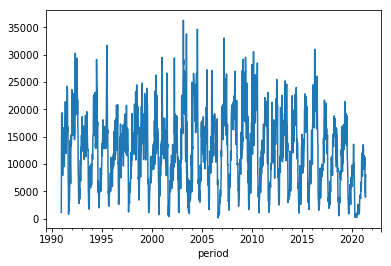

In [51]:
sorted_raw_data['inc'].plot()

on fait un zoom

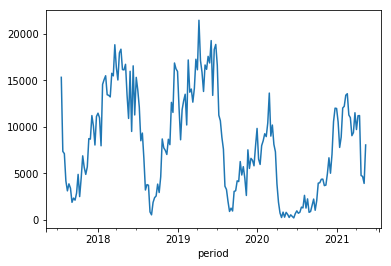

In [52]:
sorted_raw_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval entre deux années civiles, nous définissons la période de référence entre deux minima de l'incidence, du 1er septembre de l'année $N$ au 1er septembre de l'année $N+1$.
Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er septembre de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er septembre.
Comme l'incidence de syndrome de varicelle est très faible en été, cette modification ne risque pas de fausser nos conclusions.
Encore un petit détail: les données commencent en decembre 1990, ce qui rend la première année incomplète. Nous commençons donc l'analyse en 1992.L'année 2020 est incomplete nous arrêtons l'analye à 2019

In [25]:
sorted_raw_data

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   
1991-01-07/1991-01-13  199102          7  16277    11046   21508      29   
1991-01-14/1991-01-20  199103          7  15387    10484   20290      27   
1991-01-21/1991-01-27  199104          7   7913     4563   11263      14   
1991-01-28/1991-02-03  199105          7  10442     6544   14340      18   
1991-02-04/1991-02-10  199106          7  10877     7013   14741      19   
1991-02-11/1991-02-17  199107          7  12337     8077   16597      22   
1991-02-18/1991-02-24  199108          7  13289     8813   17765      23   
1991-02-25/1991-03-03  199109          7  13741     8780   18702      24   
1991-03-04/1991-03-10  199110          7  16643    11372   21914      29   
1991-03-11/1991-03-17  199111          7  15574    11184   19964      27   
1991-03-18/1991-03-24  199112          7  10864     7331   14397      19   
1991-03-25/1991-03-31  199113          7   9567     6041   13093      17   
1991-04-01/1991-04-07  199114          7  12265     7684   16846      22   
1991-04-08/1991-04-14  199115          7  13975     9781   18169      25   
1991-04-15/1991-04-21  199116          7  14857    10068   19646      26   
1991-04-22/1991-04-28  199117          7  13462     8877   18047      24   
1991-04-29/1991-05-05  199118          7  21385    13882   28888      38   
1991-05-06/1991-05-12  199119          7  16739    11246   22232      29   
1991-05-13/1991-05-19  199120          7  19053    12742   25364      34   
1991-05-20/1991-05-26  199121          7  14903     8975   20831      26   
1991-05-27/1991-06-02  199122          7  15452     9953   20951      27   
1991-06-03/1991-06-09  199123          7  11947     7671   16223      21   
1991-06-10/1991-06-16  199124          7  16171    10071   22271      28   
1991-06-17/1991-06-23  199125          7  16169    10700   21638      28   
1991-06-24/1991-06-30  199126          7  17608    11304   23912      31   
...                       ...        ...    ...      ...     ...     ...   
2020-10-19/2020-10-25  202043          7   4376     2505    6247       7   
2020-10-26/2020-11-01  202044          7   4391     2375    6407       7   
2020-11-02/2020-11-08  202045          7   3696     2016    5376       6   
2020-11-09/2020-11-15  202046          7   3752     1963    5541       6   
2020-11-16/2020-11-22  202047          7   4999     2963    7035       8   
2020-11-23/2020-11-29  202048          7   6683     4312    9054      10   
2020-11-30/2020-12-06  202049          7   5026     3145    6907       8   
2020-12-07/2020-12-13  202050          7   7063     4744    9382      11   
2020-12-14/2020-12-20  202051          7  10564     7574   13554      16   
2020-12-21/2020-12-27  202052          7  12012     8285   15739      18   
2020-12-28/2021-01-03  202053          7  11978     8406   15550      18   
2021-01-04/2021-01-10  202101          7  10525     7750   13300      16   
2021-01-11/2021-01-17  202102          7   7795     5430   10160      12   
2021-01-18/2021-01-24  202103          7   8913     6375   11451      13   
2021-01-25/2021-01-31  202104          7  12026     8826   15226      18   
2021-02-01/2021-02-07  202105          7  12210     8988   15432      18   
2021-02-08/2021-02-14  202106          7  13401     9810   16992      20   
2021-02-15/2021-02-21  202107          7  13561    10315   16807      21   
2021-02-22/2021-02-28  202108          7  11281     8361   14201      17   
2021-03-01/2021-03-07  202109          7  10988     7938   14038      17 

In [87]:
first_septembre_week =[pd.Period(pd.Timestamp(y, 9, 1), 'W')
                                  for y in range(1991,
                                                 2020)]

In [73]:
first_septembre_week

[Period('1991-08-26/1991-09-01', 'W-SUN'),
 Period('1992-08-31/1992-09-06', 'W-SUN'),
 Period('1993-08-30/1993-09-05', 'W-SUN'),
 Period('1994-08-29/1994-09-04', 'W-SUN'),
 Period('1995-08-28/1995-09-03', 'W-SUN'),
 Period('1996-08-26/1996-09-01', 'W-SUN'),
 Period('1997-09-01/1997-09-07', 'W-SUN'),
 Period('1998-08-31/1998-09-06', 'W-SUN'),
 Period('1999-08-30/1999-09-05', 'W-SUN'),
 Period('2000-08-28/2000-09-03', 'W-SUN'),
 Period('2001-08-27/2001-09-02', 'W-SUN'),
 Period('2002-08-26/2002-09-01', 'W-SUN'),
 Period('2003-09-01/2003-09-07', 'W-SUN'),
 Period('2004-08-30/2004-09-05', 'W-SUN'),
 Period('2005-08-29/2005-09-04', 'W-SUN'),
 Period('2006-08-28/2006-09-03', 'W-SUN'),
 Period('2007-08-27/2007-09-02', 'W-SUN'),
 Period('2008-09-01/2008-09-07', 'W-SUN'),
 Period('2009-08-31/2009-09-06', 'W-SUN'),
 Period('2010-08-30/2010-09-05', 'W-SUN'),
 Period('2011-08-29/2011-09-04', 'W-SUN'),
 Period('2012-08-27/2012-09-02', 'W-SUN'),
 Period('2013-08-26/2013-09-01', 'W-SUN'),
 Period('20

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.
Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [88]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_septembre_week[:-1],
                        first_septembre_week[1:]):
    one_year = sorted_raw_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
    
yearly_incidence = pd.Series(data=yearly_incidence, index=year) 

  

        
    
    

Visualisation des incidences annuelles puis de la repartition

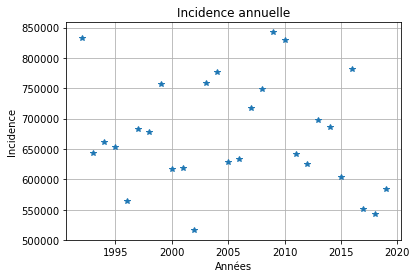

In [89]:
yearly_incidence.plot(style='*')
plt.title('Incidence annuelle')  # Ajout d'un titre
plt.xlabel('Années')         # Nom de la grandeur en abscisse
plt.ylabel('Incidence')         # Nom de la grandeur en ordonnée
plt.grid()

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [90]:
yearly_incidence.sort_values()

2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Enfin, un histogramme montre bien que les épidémies fortes, qui touchent moins de  1,5% de la population française, sont assez rares: il y en eu 4 au cours des 20 dernières années.

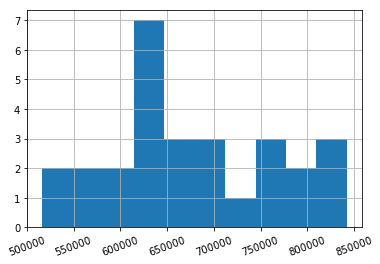

In [91]:
yearly_incidence.hist(xrot=20)

Reponse aux questions :  années du maximum d'incience et années du minimum d'incidence.

In [108]:
maxindex = np.argmax(yearly_incidence)
print(maxindex,max(yearly_incidence))

2009 842373


In [113]:
minindex = np.argmin(yearly_incidence)
print(minindex,min(yearly_incidence))

2002 516689
